In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Bidirectional,Dropout,RNN,GRUCell, LSTM, Flatten, Embedding
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *

In [2]:
yelp_data = pd.read_csv('../input/yelp-data-balanced-25/yelp_data_balanced_25.csv')
yelp_data = yelp_data[yelp_data['target'] != "Neutral"]

In [3]:
yelp_data['stars'] = yelp_data.stars.astype("int")

In [4]:
yelp_data.shape

(50000, 4)

In [5]:
yelp_data.head()

,Unnamed: 0,stars,text,target
0,0,5,Really enjoyed how clean the salon was. The na...,Positive
1,1,4,Cold War motif was not distracting. Kid and Fa...,Positive
2,2,5,I can't say enough good things about Purple Pu...,Positive
3,3,5,I will always go to Champions. The owner Migue...,Positive
4,4,4,Deceptively vast. My one-star deduction is pri...,Positive


Text(0, 0.5, 'Number of Reviews')

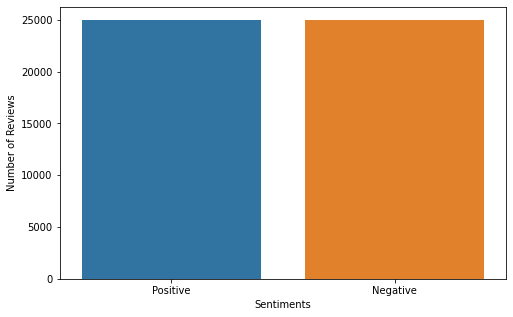

In [6]:
plot_df = yelp_data['target'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x = np.array(plot_df.index), y = np.array(plot_df.values))
plt.xlabel('Sentiments')
plt.ylabel('Number of Reviews')

In [7]:
'Review: ', yelp_data['text'][0]

('Review: ',
 "Really enjoyed how clean the salon was. The nail technicians were very friendly and kind. They did an amazing job on my nails. I've tried several locations around carmel/Indy, this is my new favorite spot.")

In [8]:
yelp_data = yelp_data.dropna()

In [9]:
yelp_data['text'] = yelp_data['text'].apply(str.lower)

In [10]:
stop_words = set(stopwords.words('english'))

In [11]:
yelp_data['text'] = yelp_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [12]:
def is_en_lang(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [13]:
yelp_data['text'] = yelp_data['text'].apply(lambda x: ' '.join([word for word in x.split() if is_en_lang(word)]))

In [14]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
yelp_data['text'] = yelp_data['text'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))

In [15]:
yelp_data['text'] = yelp_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

In [16]:
words = set(nltk.corpus.words.words())
yelp_data['text'] = yelp_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word in words]))

In [17]:
'Review: ', yelp_data['text'][0]

('Review: ',
 'really clean salon was nail friendly kind amazing job i tried several around indy new favorite spot')

In [18]:
yelp_data.head()

,Unnamed: 0,stars,text,target
0,0,5,really clean salon was nail friendly kind amaz...,Positive
1,1,4,cold war motif family friendly wait staff nice...,Positive
2,2,5,can t say enough good purple pumpkin live main...,Positive
3,3,5,always go owner awesome spend much time give c...,Positive
4,4,4,deceptively vast one star deduction primarily ...,Positive


In [19]:
yelp_data.stars.value_counts()

5    17324
1    16508
2     8492
4     7676
Name: stars, dtype: int64

In [20]:
X = yelp_data['text']
y = yelp_data['target'].to_numpy()

In [21]:
one_hot_encoder = OneHotEncoder().fit(y.reshape(-1, 1))
y_onehot = one_hot_encoder.transform(y.reshape(-1, 1)).toarray()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=16, stratify=y_onehot)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35000,), (15000,), (35000, 2), (15000, 2))

Text(0, 0.5, 'Number of Reviews')

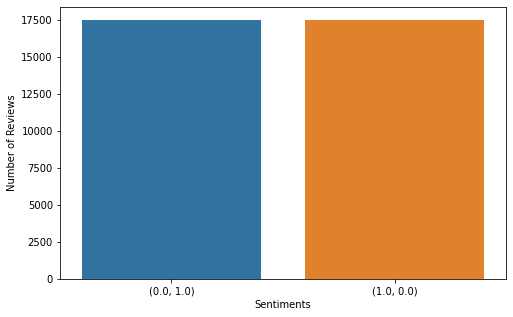

In [24]:
plot_df = pd.DataFrame(y_train).value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x = np.array(plot_df.index), y = np.array(plot_df.values))
plt.xlabel('Sentiments')
plt.ylabel('Number of Reviews')

In [25]:
vocab_size = 20000
max_length = 100
embedding_dim = 10000

In [26]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train) 

In [27]:
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_length)

In [28]:
y_train_int = y_train.astype("int")

In [29]:
print('Shape of data:', X_train_pad.shape)
print('Shape of labels:', y_train_int.shape)

Shape of data: (35000, 100)
Shape of labels: (35000, 2)


In [31]:
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_length))

model3.add(Bidirectional(LSTM(4)))
model3.add(Dropout(0.3))
model3.add(Flatten())

model3.add(Dense(4,activation='elu'))
model3.add(Dropout(0.5))

model3.add(Dense(2, activation='softmax'))

model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

2022-04-26 16:48:25.074089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 16:48:25.172934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 16:48:25.173704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 16:48:25.174807: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 10000)        200000000 
_________________________________________________________________
bidirectional (Bidirectional (None, 8)                 320160    
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [32]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0)

In [33]:
hist3 = model3.fit(X_train_pad, y_train_int,
                    epochs=5,
                    verbose=True,
                    validation_split=0.33)

Epoch 1/5


2022-04-26 16:48:27.949335: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-26 16:48:31.034876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


733/733 [==============================] - 60s 77ms/step - loss: 0.4247 - accuracy: 0.8172 - val_loss: 0.2736 - val_accuracy: 0.8959
Epoch 2/5
733/733 [==============================] - 55s 75ms/step - loss: 0.2825 - accuracy: 0.8909 - val_loss: 0.2732 - val_accuracy: 0.8976
Epoch 3/5
733/733 [==============================] - 55s 76ms/step - loss: 0.2429 - accuracy: 0.9077 - val_loss: 0.2916 - val_accuracy: 0.8950
Epoch 4/5
733/733 [==============================] - 55s 76ms/step - loss: 0.2091 - accuracy: 0.9177 - val_loss: 0.2988 - val_accuracy: 0.8961
Epoch 5/5
733/733 [==============================] - 55s 76ms/step - loss: 0.2070 - accuracy: 0.9200 - val_loss: 0.3078 - val_accuracy: 0.8975


In [34]:
X_test_sequences = tokenizer.texts_to_sequences(X_test) 
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_length)
y_test_int = y_test.astype("int")

In [35]:
print("Evaluate on test data")
results = model3.evaluate(X_test_pad, y_test_int)
print("test loss, test acc:", results)

Evaluate on test data
469/469 [==============================] - 6s 12ms/step - loss: 0.3090 - accuracy: 0.8971
test loss, test acc: [0.3089860677719116, 0.8971333503723145]


In [36]:
y_pred = model3.predict(X_test_pad)

In [38]:
matrix = confusion_matrix(y_test_int.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[6802,  698],
       [ 845, 6655]])

In [39]:
print('Precision Score: ', precision_score(y_test_int.argmax(axis=1), y_pred.argmax(axis=1), average="macro"))
print('Recall Score: ', recall_score(y_test_int.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
print('F1 Score: ',f1_score(y_test_int.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
print('Accuracy Score: ',accuracy_score(y_test_int.argmax(axis=1), y_pred.argmax(axis=1)))

Precision Score:  0.8972859547056931
Recall Score:  0.8971333333333333
F1 Score:  0.8971234530697662
Accuracy Score:  0.8971333333333333
